### Import data

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_csv('./data/comp1/train.csv')
print(df.head(5))
df_test = pd.read_csv('./data/comp1/test.csv')
print(df_test.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...
      Id                                       Page content
0  27643  <html><head><div class="article-info"><span cl...
1  27644  <html><head><div class="article-info"><span cl...
2  27645  <html><head><div class="article-info"><span cl...
3  27646  <html><head><div class="article-info"><span cl...
4  27647  <html><head><div class="article-info"><span cl...


### Preprocess data

In [2]:
def soup(text):
    # remove HTML tags
    return BeautifulSoup(text, 'html.parser')

def select_tag(text, tag):
    # remove HTML tags
    return BeautifulSoup(text, 'html.parser').select(tag)[0].text.strip()

def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [ ]:
def checkAuthor(soup):
    if len(soup.select('.author_name a')) == 0:
        return ''
    else:
        return soup.select('.author_name a')[0].text
    
def flatten(arr_2D):
    result = []
    for arr in arr_2D:
        if len(arr) == 0:
            result.append(np.nan)
        else:
            result.append(arr.text)
    return result

In [ ]:
df['result'] = df['Page content'].map(lambda x: soup(x))
df['author'] = df['result'].map(lambda x: checkAuthor(x))
df['time'] = df['result'].map(lambda x: x.select('time')[0].text)
df['time'] = df['time'].map(lambda x : datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'))

df['topic'] = df['result'].map(lambda x: x.select('.article-topics a'))
df['image num'] = df['result'].map(lambda x: len(x.select('img')))
df['video num'] = df['result'].map(lambda x: len(x.select('iframe')))
df['body'] = df['result'].map(lambda x: x.select('body')[0].text.strip())

df['topic'] = df['topic'].map(lambda x: flatten(x))

In [ ]:
df['week of day'] = df['time'].map(lambda x: x.isoweekday() )
df['year'] = df['time'].map(lambda x: x.year )
df['month'] = df['time'].map(lambda x: x.month )
df['hour'] = df['time'].map(lambda x: x.hour )

In [ ]:
df['weekend'] = df['week of day']
mask = df['weekend'] > 5 
df.loc[mask, 'weekend'] = 1
df.loc[~mask, 'weekend'] = 0

In [ ]:
df.drop(columns=['result']).to_csv('data/train_new_feature1.csv')

### Import preprocessed data

In [2]:
import pickle

with open('objs_topic_featurehash.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    doc_hash, doc_y_label, doc_hash_test, doc_hash_test_np = pickle.load(f)
print(doc_hash.shape, doc_y_label.shape, doc_hash_test.shape, doc_hash_test_np.shape)

(27643, 2056) (27643,) (11847, 2056) (11847, 2056)


The `objs_topic_featurehash.plk` contains:
1. **body (1024-dim)**: Capture the content in `<body>`, transform to vector by `HashingVectorizer()` with TA's `preprocessor()` and `tokenizer_stem_nostop()`.
2. **topic (1024-dim)**: Capture the content in `<topic>`, transform to vector by `HashingVectorizer()` with TA's `preprocessor()` and `tokenizer_stem_nostop()`.
3. **author (1-dim)**: Capture the content in `<a href="/author/.../">`, encode every author with an unique ID.
4. **img num (1-dim)**: Count the number of `<img>`.
5. **video num (1-dim)**: Count the number of `<video>`.
6. **week of day (1-dim)**: Map "Monday" to "1", "Tuesday" to "2", ..., "Sunday" to "7". 
7. **weekend (1-dim)**: 1 if `week of day` is bigger than 5, else 0.
8. **month (1-dim)**: a number range from 1 to 12.
9. **hour (1-dim)**: a number range from 0 to 23.
10. **year (1-dim)**: a number of year.<br>

, which is total 2056 dimemsions. We import it for further preprocessing as below.

### Construct feature 1: Id

**Id (1-dim)** just for anchoring.

In [3]:
import numpy as np
new_feature_x = np.array(df['Id']).reshape(-1,1)
print("Id(1)", new_feature_x.shape)

new_feature_x_test = np.array(df_test['Id']).reshape(-1,1)
print("Id(1)", new_feature_x_test.shape)

Id(1) (27643, 1)
Id(1) (11847, 1)


### Construct feature 2: body&topic

**body&topic (201-dim)** <br>
Further preprocess the **body (1024-dim)** and **topic (1024-dim)** in `objs_topic_featurehash.plk` by choosing the important dimensions that have bigger than 0.01 correlation with the Popularity.

In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # scikit-learn 0.21.3
import seaborn as sns # seaborn 0.9.0
x = doc_hash.toarray()[:,:-8]
print(x.shape)
print(np.array(df['Popularity']).reshape(-1,1).shape)
x = np.append(x,np.array(df['Popularity']).reshape(-1,1),axis=1)
print(x.shape)

sc = StandardScaler()
Z = sc.fit_transform(x)
# Estimate the correlation matrix
R = np.dot(Z.T, Z) / df.shape[0]

reshape = []
for idx, item in enumerate(R[-1]):
    if item>0.01: # find the important component in body&topic: 2048-dim
        reshape.append(idx)
print(len(reshape))
print(reshape)

(27643, 2048)
(27643, 1)
(27643, 2049)
202
[6, 11, 16, 17, 26, 27, 33, 48, 52, 65, 73, 74, 102, 117, 120, 124, 164, 169, 172, 175, 190, 196, 198, 202, 230, 239, 250, 258, 273, 274, 310, 316, 330, 337, 355, 397, 412, 426, 459, 482, 500, 507, 515, 523, 524, 525, 531, 536, 543, 546, 567, 569, 572, 586, 590, 604, 608, 619, 621, 648, 649, 665, 699, 700, 704, 714, 724, 761, 765, 768, 769, 781, 782, 790, 799, 806, 820, 827, 838, 844, 847, 880, 882, 884, 887, 888, 895, 896, 897, 898, 901, 912, 913, 919, 936, 949, 953, 958, 987, 991, 1000, 1003, 1011, 1018, 1020, 1021, 1032, 1035, 1041, 1051, 1076, 1077, 1080, 1085, 1143, 1174, 1214, 1246, 1263, 1328, 1329, 1334, 1339, 1340, 1347, 1354, 1361, 1379, 1400, 1423, 1436, 1446, 1447, 1450, 1461, 1483, 1506, 1524, 1531, 1539, 1544, 1548, 1562, 1570, 1573, 1591, 1603, 1606, 1610, 1611, 1618, 1625, 1627, 1628, 1632, 1641, 1643, 1655, 1668, 1669, 1673, 1678, 1687, 1719, 1723, 1730, 1739, 1780, 1787, 1789, 1797, 1816, 1827, 1832, 1834, 1840, 1844, 1845, 1

The line 4 **"202"** of the above result means there's only 201+1 dimensions that have bigger than 0.01 correlation with the Popularity (the "+1" indicates the correlation between Popularity and Popularity, which should not count in). Therefore, we reconstruct original 2048 dimensions to 201.

In [5]:
del x, sc, Z, R

In [6]:
for i in reshape[:-1]: # drop the high correlation between Popularity and Popularity
    new_feature_x = np.append(new_feature_x, doc_hash.toarray()[:,i].reshape(-1,1),axis=1)
    new_feature_x_test =  np.append(new_feature_x_test, doc_hash_test.toarray()[:,i].reshape(-1,1),axis=1)
print('body&topic: 2048 to 201',new_feature_x.shape)
print('body&topic: 2048 to 201',new_feature_x_test.shape)   

body&topic: 2048 to 201 (27643, 202)
body&topic: 2048 to 201 (11847, 202)


### Construct feature 3: week of day and weekend

**week of day (1-dim)**: Map "Monday" to "1", "Tuesday" to "2", ..., "Sunday" to "7".<br>
**weekend (1-dim)**: 1 if week of day is bigger than 5, else 0.

In [7]:
new_feature_x = np.append(new_feature_x, doc_hash.toarray()[:,-5:-3],axis=1)
print('week of day(1)', 'weekend(1)',new_feature_x.shape)
new_feature_x_test = np.append(new_feature_x_test, doc_hash_test.toarray()[:,-5:-3],axis=1)
print('week of day(1)', 'weekend(1)',new_feature_x_test.shape)

week of day(1) weekend(1) (27643, 204)
week of day(1) weekend(1) (11847, 204)


### Construct feature 4: toEndOfYear

**toEndOfYear (1-dim)**: the numbers of remain days from the date of the articale to 12/31 of the same year.

In [8]:
from bs4 import BeautifulSoup
from datetime import datetime,date
toEndOfYear = []
for i in df['Page content']:
    soup = BeautifulSoup(i, 'html.parser')
    time = list(soup.find('time'))[0].split(' ')
    now = datetime.strptime(time[0], "%Y-%m-%d").date()
    endOfYear = date(now.year,12,31)
    toEndOfYear.append((endOfYear - now).days)    
new_feature_x = np.append(new_feature_x, np.array(toEndOfYear).reshape(-1,1),axis=1)
print('toEndOfYear(1)',new_feature_x.shape)

toEndOfYear_test = []
for i in df_test['Page content']:
    soup = BeautifulSoup(i, 'html.parser')
    if len(list(soup.find('time'))) != 0:
        time = list(soup.find('time'))[0].split(' ')
        now = datetime.strptime(time[0], "%Y-%m-%d").date()
        endOfYear = date(now.year,12,31)
        toEndOfYear_test.append((endOfYear - now).days)
    else:
        toEndOfYear_test.append(int(178))
new_feature_x_test = np.append(new_feature_x_test, np.array(toEndOfYear_test).reshape(-1,1),axis=1)
print('toEndOfYear(1)',new_feature_x_test.shape)

toEndOfYear(1) (27643, 205)
toEndOfYear(1) (11847, 205)


In [9]:
del toEndOfYear, toEndOfYear_test

### Construct feature 5: title

Simialr preprocess to the **body&topic (201-dim)**, we 
1. capture the content in `<h1>`
2. transform to 1024-dim vectors by `HashingVectorizer()` with TA's `preprocessor()` and `tokenizer_stem_nostop()`
3. choosing the important dimensions that have bigger than 0.01 correlation with the Popularity
4. reconstruct features from 1024 dimensions to 76 dimensions.<br>

Therefore, we have **title (76-dim)**.

In [10]:
from bs4 import BeautifulSoup
from datetime import datetime,date
title = []
for i in df['Page content']:
    soup = BeautifulSoup(i, 'html.parser')
    t = list(soup.find('h1'))[0]
    title.append(t)

print(len(title))

27643


In [11]:
title_test = []
for i in df_test['Page content']:
    soup = BeautifulSoup(i, 'html.parser')
    t = list(soup.find('h1'))[0]
    title_test.append(t)

print(len(title_test))

11847


In [12]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

# print(tokenizer_stem_nostop('runners like running and thus they run'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from sklearn.feature_extraction.text import HashingVectorizer
hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem_nostop)

title_hash = hashvec.transform(title).toarray()
print(title_hash.shape)
title_hash = np.append(title_hash,np.array(df['Popularity']).reshape(-1,1),axis=1)
print(title_hash.shape)

sc = StandardScaler()
Z = sc.fit_transform(title_hash)
# Estimate the correlation matrix
R = np.dot(Z.T, Z) / df.shape[0]

reshape = []
for idx, item in enumerate(R[-1]):
    if item>0.01: # find the important component in body&topic: 2048-dim
        reshape.append(idx)
print(len(reshape))
print(reshape)

# new_feature_x = np.append(new_feature_x, title_hash.toarray(),axis=1)
# print('title(32)',new_feature_x.shape)
# title_hash_test = hashvec.transform(title_test)
# new_feature_x_test = np.append(new_feature_x_test, title_hash_test.toarray(),axis=1)
# print('title(32)',new_feature_x_test.shape)

(27643, 1024)
(27643, 1025)
77
[3, 7, 11, 25, 27, 29, 45, 49, 52, 73, 99, 100, 120, 150, 164, 169, 173, 175, 190, 196, 198, 239, 258, 274, 298, 310, 316, 337, 340, 366, 389, 410, 416, 421, 440, 451, 459, 464, 467, 468, 482, 486, 489, 491, 492, 507, 515, 525, 536, 569, 586, 590, 603, 619, 636, 649, 651, 701, 737, 743, 747, 760, 761, 765, 785, 837, 842, 881, 884, 901, 930, 953, 956, 968, 1012, 1021, 1024]


In [14]:
title_hash_test = hashvec.transform(title_test).toarray()

for i in reshape[:-1]: # drop the high correlation between Popularity and Popularity
    new_feature_x = np.append(new_feature_x, title_hash[:,i].reshape(-1,1),axis=1)
    new_feature_x_test =  np.append(new_feature_x_test, title_hash_test[:,i].reshape(-1,1),axis=1)
print('title: 1024 to 76',new_feature_x.shape)
print('title: 1024 to 76',new_feature_x_test.shape)   

title: 1024 to 76 (27643, 281)
title: 1024 to 76 (11847, 281)


To summary, we have **total 281-dim features**, including
1. **Id (1-dim)**
2. **body&topic (201-dim)**
3. **week of day (1-dim) and weekend (1-dim)**
4. **toEndOfYear (1-dim)**
5. **title (76-dim)**

### GridSearchCV for the best model

In [15]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV


# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'probability': [True, True]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters, n_jobs=-1, cv=10, scoring='roc_auc')
rf = RandomForestClassifier()
parameters = {'n_estimators':[800],"max_depth": [25]}
clf = GridSearchCV(rf, parameters, n_jobs=-1, cv=10, scoring='roc_auc')

clf.fit(new_feature_x, doc_y_label)
print(clf.best_params_, "score: ", clf.best_score_)
print(clf.cv_results_)

{'max_depth': 25, 'n_estimators': 800} score:  0.5900676817530393
{'mean_fit_time': array([102.97859445]), 'std_fit_time': array([9.31561422]), 'mean_score_time': array([0.66583064]), 'std_score_time': array([0.11241634]), 'param_max_depth': masked_array(data=[25],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[800],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 25, 'n_estimators': 800}], 'split0_test_score': array([0.58281796]), 'split1_test_score': array([0.61291683]), 'split2_test_score': array([0.57444463]), 'split3_test_score': array([0.58128273]), 'split4_test_score': array([0.58679865]), 'split5_test_score': array([0.60446081]), 'split6_test_score': array([0.56437991]), 'split7_test_score': array([0.59127717]), 'split8_test_score': array([0.61267892]), 'split9_test_score': array([0.5896192]), 'mean_test_score': array([0.59006768]), 'std_test_score': arra

Here only shows one set of parameters ('max_depth': 25, 'n_estimators': 800), which is selected among all other settings we have run in other notebooks.

### Remove NaN in testing data and predict it

There's a testing data without datetime information, which would cause NaN in our program. Therefore, we remove it here.

In [16]:
for idx,i in enumerate(new_feature_x_test):
    for idxx,j in enumerate(i):
        if np.isnan(j):
            print(idx,idxx,j)
            
new_feature_x_test.data = np.nan_to_num(new_feature_x_test.data)

for idx,i in enumerate(new_feature_x_test):
    for idxx,j in enumerate(i):
        if np.isnan(j):
            print(idx,idxx,j)

pred = clf.predict_proba(new_feature_x_test) # predict the proba of -1 and 1
df_all_pred = pd.concat([df_test['Id'],pd.DataFrame(pred[:,1])], axis=1).rename(columns={0: 'Popularity'})
print(df_all_pred.head())

1585 202 nan


<ipython-input-16-19593a7135b0>:6: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  new_feature_x_test.data = np.nan_to_num(new_feature_x_test.data)


      Id  Popularity
0  27643    0.459656
1  27644    0.430134
2  27645    0.448130
3  27646    0.509935
4  27647    0.463551


In [17]:
df_all_pred.to_csv('./data/comp1/RF_281-dim_pred.csv', index=None)

### Show the correlation between each dimension of 281 features and Popularity

In [18]:
x = np.append(new_feature_x,np.array(df['Popularity']).reshape(-1,1),axis=1)
print(x.shape)

sc = StandardScaler()
Z = sc.fit_transform(x)
# Estimate the correlation matrix
R = np.dot(Z.T, Z) / df.shape[0]

print(R[-1])

(27643, 282)
[0.00119136 0.01400685 0.01744375 0.01534015 0.01646194 0.01276709
 0.01276669 0.01121084 0.01037327 0.01984503 0.01390659 0.02034764
 0.01546031 0.01196157 0.01061204 0.01169194 0.0297663  0.01191991
 0.01243966 0.01056702 0.02518365 0.01089286 0.01329412 0.01022101
 0.01005112 0.0147265  0.01127935 0.01420136 0.0112382  0.01312126
 0.01850545 0.0213941  0.02931966 0.01180224 0.01042016 0.01196934
 0.01242626 0.01369141 0.01167228 0.01118573 0.01749977 0.01718265
 0.02949877 0.02473368 0.01405626 0.02383778 0.02101989 0.01326183
 0.01091284 0.01175075 0.01303808 0.01008893 0.01366026 0.01325441
 0.02392093 0.01442492 0.02084844 0.01546183 0.01565638 0.01504191
 0.01037914 0.01433222 0.01092801 0.0152073  0.01066242 0.01059173
 0.01009319 0.01168651 0.02008007 0.01123014 0.0172594  0.011718
 0.01018936 0.01131505 0.01020091 0.01136684 0.01329954 0.02030138
 0.01109559 0.01351797 0.01274761 0.01022145 0.01012965 0.01492103
 0.01263453 0.01101768 0.01103788 0.01569743 0.0118

From the matrix above, expect the first dimension (indicating **Id (1-dim)**), there's no dimension that have lower than 0.01 correlation against Popularity

### Show the importance rank of 281 dimensions in RandomForestClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=800, 
                                max_depth=25,
                                n_jobs=-1)
forest.fit(new_feature_x, doc_y_label)


RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=800,
                       n_jobs=-1)

 1) toEndOfYear                    0.036051
 2) Id                             0.020217
 3) week of day                    0.019970
 4) body&topic5                    0.017210
 5) body&topic31                   0.015457
 6) body&topic100                  0.014522
 7) body&topic33                   0.013580
 8) body&topic70                   0.012262
 9) body&topic88                   0.011927
10) weekend                        0.011800
11) body&topic8                    0.011777
12) body&topic9                    0.011720
13) body&topic37                   0.011459
14) body&topic93                   0.011354
15) body&topic42                   0.011285
16) body&topic50                   0.010917
17) body&topic87                   0.010864
18) body&topic62                   0.010859
19) body&topic81                   0.010814
20) body&topic82                   0.010799
21) body&topic28                   0.010606
22) body&topic83                   0.010595
23) body&topic36                

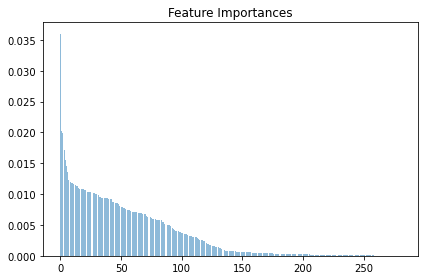

In [21]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

listOfBody = []
for i in range(201):
    listOfBody.append("body&topic{0}".format(i))

listOfCate = []
for i in range(76):
    listOfCate.append("title{0}".format(i))
X_col_name = ["Id"]+listOfBody+['week of day', 'weekend', 'toEndOfYear']+listOfCate

for f in range(new_feature_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_col_name[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(new_feature_x.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.tight_layout()
plt.show()